In [12]:
from collections import defaultdict

def indexes(l, chosen_key):
    _indices = defaultdict(list)
    for index, item in enumerate(l):
        _indices[item].append(index)

    for key, value in _indices.items():
        if key == chosen_key:
            return value
#indexes(labels, 0)

In [44]:
from mne import EpochsArray
import numpy as np
import matplotlib.pyplot as plt
import mne
import pandas as pd
from scipy import signal
from autoreject import AutoReject

dataset_name = 'BrainCommand'
dataset_info = {  # BrainCommand
                    'dataset_name': 'BrainCommand',
                    '#_class': 4,
                    "target_names": ['Derecha', 'Izquierda', 'Arriba', 'Abajo'],
                    '#_channels': 8,
                    'samples': 350,  # 250*1.4
                    'sample_rate': 250,
                    'channels_names': ['C4', 'FC3', 'F5', 'C3', 'F7', 'Cz', 'P3', 'C5'],
                    'subjects': 0,  # PENDING
                    'total_trials': 228,
                    }

def data_normalization(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def remove_too_different_trials_v2(data: np.array, label) -> np.array:
    data_cleaned = []
    label_cleaned = []
    for word_index in range(len(dataset_info["target_names"])):
        indexes_from_word = indexes(label, word_index)
        for i_index in indexes_from_word:
            trial = data[i_index,:,:]
            trial_label = label[i_index]
            if np.mean(np.abs(trial)) < np.mean(np.abs(data[indexes_from_word,:,:]))*1.5 :
                data_cleaned.append(trial)
                label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def remove_too_different_trials_v1(data: np.array, label) -> np.array: #todo: decide which one is better when you get more data
    average_of_trials: int = np.mean(np.abs(data))
    data_cleaned = []
    label_cleaned = []
    for trial, trial_label in zip(data, label):
        if np.mean(np.abs(trial)) < average_of_trials*1.5 :
            data_cleaned.append(trial)
            label_cleaned.append(trial_label)
    return np.array(data_cleaned), label_cleaned

def convert_to_epochs(data, labels):
    events = np.column_stack((
        np.arange(0, dataset_info['sample_rate'] * data.shape[0], dataset_info['sample_rate']),
        np.zeros(len(labels), dtype=int),
        np.array(labels),
    ))

    event_dict = {'Arriba': 2, 'Abajo': 3, 'Derecha': 0, 'Izquierda': 1}

    epochs = EpochsArray(data, info=mne.create_info(
        sfreq=dataset_info['sample_rate'], ch_types='eeg', ch_names=dataset_info['channels_names']), events=events,
                         event_id=event_dict)
    montage = mne.channels.make_standard_montage('standard_1020')
    epochs.set_montage(montage)

    ar = AutoReject()
    epochs = ar.fit_transform(epochs)
    return epochs.get_data(), epochs.events[:, -1]

def braincommand_dataset_loader(game_mode: str, subject_id: int):
    complete_information = pd.read_csv(f'assets/game_saved_files/eeg_data_{game_mode}_sub{subject_id:02d}.csv')
    x_list = list(complete_information['time'].apply(eval))
    label = list(complete_information['class'][1:])# The first movement never have the data complete, that is because the first blue is just to show position. The start movement is in its place.

    label_0 = label.count(0)
    print(f"label 0 is {label_0}")

    label_1 = label.count(1)
    print(f"label 1 is {label_1}")

    label_2 = label.count(2)
    print(f"label 2 is {label_2}")

    label_3 = label.count(3)
    print(f"label 3 is {label_3}")

    x_array = np.array(x_list[1:]) # trials, time, channels
    x_array = x_array[:, :, :-9] # The last channels are accelerometer (x3), gyroscope (x3), validity, battery and counter
    x_array = np.transpose(x_array, (0, 2, 1))
    x_array = signal.detrend(x_array)
    x_array, label = convert_to_epochs(x_array, label)
    x_array = data_normalization(x_array)
    return x_array, label


subject_id = 24
game_mode = 'singleplayer'
event_dict = {'Arriba': 2, 'Abajo': 3, 'Derecha': 0,'Izquierda': 1}

data, labels = braincommand_dataset_loader(game_mode, subject_id)


events = np.column_stack((
    np.arange(0, dataset_info['sample_rate'] * data.shape[0], dataset_info['sample_rate']),
    np.zeros(len(labels), dtype=int),
    np.array(labels),
))

epochs = EpochsArray(data, info=mne.create_info(
                        sfreq=dataset_info['sample_rate'], ch_types='eeg', ch_names=dataset_info['channels_names']), events=events,
                     event_id=event_dict)
montage = mne.channels.make_standard_montage('standard_1020')
epochs.set_montage(montage)

label 0 is 105
label 1 is 100
label 2 is 29
label 3 is 145
Not setting metadata
379 matching events found
No baseline correction applied
0 projection items activated
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/8 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/8 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/379 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/379 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/379 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/379 [00:00<?,       ?it/s]

C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\bem.py:1127: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\rosit\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/379 [00:00<?,       ?it/s]

Dropped 113 epochs: 9, 16, 17, 18, 34, 39, 46, 54, 61, 71, 90, 110, 123, 128, 185, 197, 239, 242, 245, 247, 248, 250, 251, 252, 254, 255, 256, 257, 258, 260, 261, 262, 263, 264, 266, 267, 268, 269, 270, 272, 274, 275, 276, 281, 282, 284, 285, 286, 287, 288, 289, 291, 308, 311, 312, 313, 314, 315, 316, 318, 319, 320, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 338, 339, 340, 342, 343, 344, 345, 346, 347, 348, 349, 350, 352, 354, 355, 356, 357, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 375, 376, 377, 378
Not setting metadata
266 matching events found
No baseline correction applied
0 projection items activated


Number of events,266
Events,Abajo: 104Arriba: 12Derecha: 76Izquierda: 74
Time range,0.000 – 1.396 s
Baseline,off


In [45]:
len(labels)

266

In [46]:
#epochs.plot(block=True)

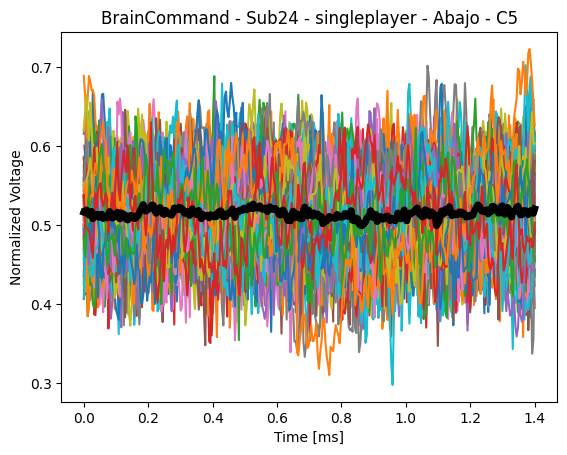

In [47]:
samples_to_time = np.linspace(0, dataset_info["samples"]/dataset_info["sample_rate"], num=dataset_info["samples"])
for channel in range(len(dataset_info["channels_names"])):
    for word_index in range(len(dataset_info["target_names"])):
        plt.clf()
        indexes_from_word = indexes(labels, word_index)
        for i_index in indexes_from_word:
            plt.plot(samples_to_time, data[i_index,channel,:])
        plt.plot(samples_to_time, np.mean(data[indexes_from_word,channel,:], axis=0), linewidth=5, color='k')
        plt.title(f'{dataset_name} - Sub{subject_id:02d} - {game_mode} - {dataset_info["target_names"][word_index]} - {dataset_info["channels_names"][channel]}')
        plt.xlabel('Time [ms]')
        plt.ylabel('Normalized Voltage')
        plt.savefig(f'assets/ERP/ERP_{dataset_name}_sub{subject_id:02d}_{game_mode}_{dataset_info["target_names"][word_index]}_{dataset_info["channels_names"][channel]}.png')

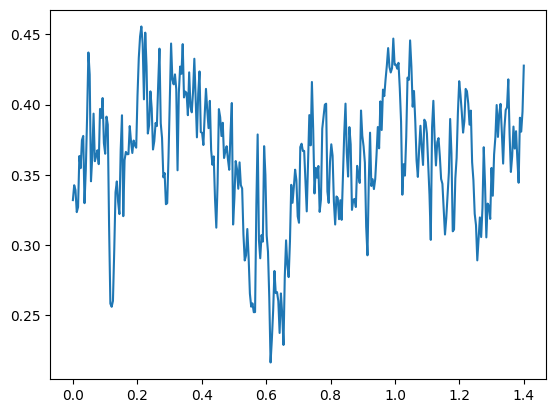

In [42]:
plt.clf()
plt.plot(samples_to_time,data[100,7,:])

In [43]:
def identify_flatlines(ts, threshold=0.005): # semi-works.
    for j in range(len(ts)-6):
        if abs(ts[j] - ts[j+3]) <= threshold:
            if abs(ts[j] - ts[j+4]) <= threshold:
                if abs(ts[j] - ts[j+5]) <= threshold:
                    if abs(ts[j] - ts[j+6]) <= threshold:
                        return 1
    else:
        return 0

In [35]:
identify_flatlines(data[18,7,:])

1

In [36]:
count_trials_with_flatlines = []
for trial in range(len(labels)):
    count_trials_with_flatlines.append(identify_flatlines(data[trial,3,:])) # Channel doesnt matter, when the signal stagnates it happens to all of them.
sum(count_trials_with_flatlines)

175

In [37]:
len(labels)

187

# Do the XDAWN DENOISING HERE AND SEE THE SIGNALS
https://mne.tools/stable/auto_examples/preprocessing/xdawn_denoising.html#sphx-glr-auto-examples-preprocessing-xdawn-denoising-py

In [22]:
# from mne.preprocessing import Xdawn
# from mne.viz import plot_epochs_image
# 
# plot_epochs_image(epochs)
# # Estimates signal covariance
# signal_cov = mne.compute_covariance(epochs)
# 
# # Xdawn instance
# xd = Xdawn(n_components=2, signal_cov=signal_cov)
# 
# # Fit xdawn
# xd.fit(epochs)
# 
# epochs_denoised = xd.apply(epochs)
# 
# # Plot image epoch after Xdawn
# plot_epochs_image(epochs_denoised['Arriba']) # todo: previously you should had made 'picks' and the event dict only dedicated to one event, otherwise it joins eveything